# Обучение однослойного персептрона методом стохастического градиентного спуска

Цель работы. Изучить алгоритм обучения однослойного персептрона методом стохастического градиентного спуска.
Задание. Построить и обучить нейронную сеть для распознавания цифровых рукописных символов из базы данных MNIST (Mixed National Institute of Standards and Technology database). \\
 Нейронная сеть должна корректно распознавать образы из тестовой выборки в большинстве случаев. Общий процент ошибки распознавания образов не должен быть выше 20%.

## Загрузка и представление даных


Датасет MNIST взят отсюда: https://www.kaggle.com/datasets/vikramtiwari/mnist-numpy?resource=download

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls drive/MyDrive/labs/
PATH = '/content/drive/MyDrive/labs/mnist.npz'


mnist.npz  Test  Train


In [6]:
import numpy as np

In [7]:
def load_data(path):
    with np.load(path, allow_pickle=True) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data(PATH)

In [8]:
print('Data shapes: ')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

Data shapes: 
X_train:  (60000, 28, 28)
y_train:  (60000,)
X_test:  (10000, 28, 28)
y_test:  (10000,)


### Визуализация данных:

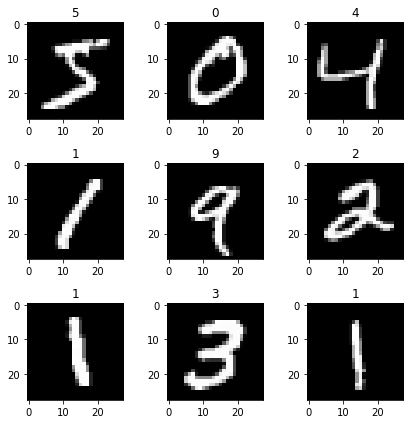

In [10]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6,6))
a, b = 3, 3
for i in range(a*b):  
    plt.subplot(b, a, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(str(y_train[i]))
plt.tight_layout()
plt.show()

In [11]:
y_train[0:9]

array([5, 0, 4, 1, 9, 2, 1, 3, 1], dtype=uint8)

In [15]:
import os
import torch
import torchvision

class Dataset_train(torch.utils.data.Dataset):
    def __init__(self, transform):
        self.transform = transform

        (X_train, y_train), (_, _) = load_data(PATH)

        self.X_train = X_train
        self.y_train = y_train
        self.classes = len(np.unique(self.y_train))

    def __getitem__(self, idx):
        image = self.X_train[idx]
        label = self.y_train[idx]
        if self.transform:
            image = self.transform(image)
            label = torch.tensor(label)
        image = image.reshape(-1)
        return image.float(), label.float()
    
    def __len__(self):
        return self.X_train.shape[0]

import torchvision
from torch.utils.data import DataLoader

train_dataset = Dataset_train(transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Задание архитектуры модели

Создадим однослойный персептрон с 28*28 входными нейронами и выходом размера 10 - вектором вероятности класса. \\


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, LogSoftmax

In [17]:
input_size = X_train.shape[1] * X_train.shape[2]
output_size = 10

batch_size = 64

In [18]:
loss_curves = []
device = 'cuda'

model = torch.nn.Sequential(
     Linear(input_size, output_size),
     LogSoftmax(),
 ).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
num_epoch = 50
losses = []
acc = []

## Обучающий цикл:

Функция потерь - кросс-энтропияю \\
Метод оптимизации - стохастический градиентный спуск \\
Критерий останова - количество эпох

In [19]:
for epoch in range(num_epoch):
    loss_curve = []
    accuracy_curve = []
    for i, (train_features, train_labels) in enumerate(train_dataloader):
        X = train_features.to(device)
        y = train_labels.type(torch.LongTensor).to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        accuracy = ((torch.max(y_pred.data, 1)[1] == y).sum() / len(y)).cpu().detach().numpy()
        accuracy_curve.append(accuracy)
        loss_curve.append(loss.cpu().detach().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(np.mean(loss_curve))
    acc.append(np.mean(accuracy_curve))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


## Анализ обучающего цикла:



Text(0, 0.5, 'loss')

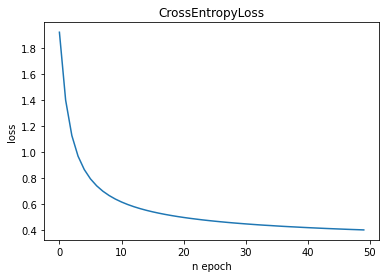

In [20]:
plt.plot(losses)
plt.title('CrossEntropyLoss')
plt.xlabel('n epoch')
plt.ylabel('loss')

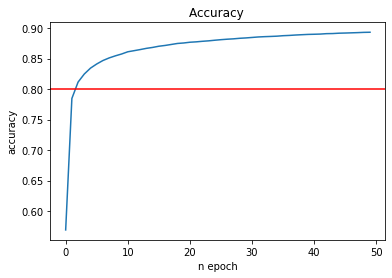

In [21]:
plt.plot(acc)
plt.title('Accuracy ')
plt.xlabel('n epoch')
plt.ylabel('accuracy')
plt.axhline(y=0.8, color='r', linestyle='-')

Видим, что функция потерь выходит на константу, что говорит об успешном обучении. Проверим это на тестовой выборке:

## Тестирование

In [24]:
test_preds = torch.argmax(model(torch.Tensor(X_test.reshape(X_test.shape[0], 784)).to(device)), 1).detach().cpu().numpy()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [23]:
from sklearn.metrics import accuracy_score

In [25]:
print(accuracy_score(y_test, test_preds))

0.8973


In [26]:
wrong_answers = y_test != test_preds
bad_classification_X = X_test[wrong_answers][0:9]
wrong_preds = test_preds[wrong_answers]

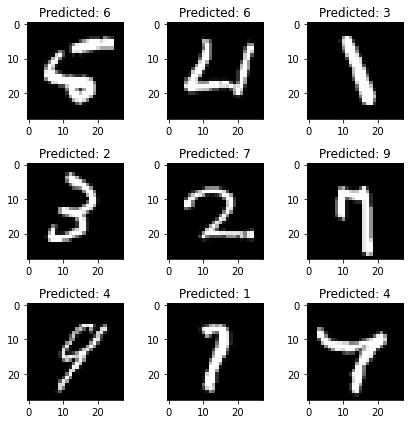

In [27]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6,6))
a, b = 3, 3
for i in range(a*b):  
    plt.subplot(b, a, i+1)
    plt.imshow(bad_classification_X.reshape(9, 28, 28)[i], cmap='gray')
    plt.title("Predicted: "+str(wrong_preds[i]))
plt.tight_layout()
plt.show()

In [28]:
right_answers = y_test == test_preds
good_classification_X = X_test[right_answers][0:9]
right_preds = test_preds[right_answers]

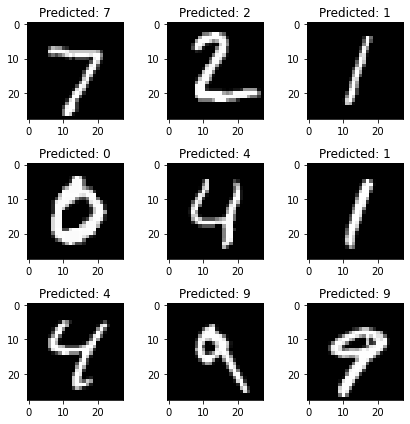

In [29]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6,6))
a, b = 3, 3
for i in range(a*b):  
    plt.subplot(b, a, i+1)
    plt.imshow(good_classification_X.reshape(9, 28, 28)[i], cmap='gray')
    plt.title("Predicted: "+str(right_preds[i]))
plt.tight_layout()
plt.show()

На тестовой выборке достигнуто требуемое по условию качество классификации - 0.88

## Выводы:

Нейросеть предложенной архитектуры успешно справляется с задачей.